# Les bennes à verre dans la CALL

La source des données provient de : https://opendata.agglo-lenslievin.fr/ <br>
Il y a eu un traitement des données, plus de detail sur le notebook [Analyse_dataset](Analyse_dataset.ipynb) <br>


In [1]:
#import des bibliothèques
import locale


import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns

import fonctions.perso_reg_lin as perso_reg_lin


In [2]:
def scatter_text(ax,x, y, text_column, data):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(data=data,x=x,y=y, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')   

In [3]:
#definit la norme fr pour les chiffre par exempple
locale.setlocale(locale.LC_NUMERIC, 'fr_FR.UTF-8')

# import des fichiers
benne_verre = pd.read_csv('donnee/benne_verre.csv')

#import carte
font_carte = gpd.read_file('donnee/font_carte.gdp')
carte_benne = gpd.read_file('donnee/carteverre.gpd/')

In [4]:
sns.set_theme(style='dark')
palette=sns.color_palette()

## Généralité :

In [5]:
#affichage moyenne generale
total_nb_benne = int(benne_verre['nb_benne'].sum())
total_volume = int(benne_verre['volume_borne__m3_'].sum())
total_population = int(benne_verre['Population_municipale_2020'].sum())
nb_commune = benne_verre['commune'].count()
print("La population de la CALL en 2020 est de", '{:n}' .format(total_population),"habitants")
print("Il y a ",total_nb_benne,"bennes de verre sur le territoire pour un volume total de",total_volume,"m³")
print("Il y a donc",int(total_population/total_nb_benne),"habitants pour chaque benne en moyenne")
#cliiikk
total_cliink = benne_verre['cliiink'].sum()
print("Il y a ",total_cliink/total_nb_benne*100,"% de benne qui ont l'option CLIIINK")

La population de la CALL en 2020 est de 242 238 habitants
Il y a  500 bennes de verre sur le territoire pour un volume total de 1521 m³
Il y a donc 484 habitants pour chaque benne en moyenne
Il y a  39.0 % de benne qui ont l'option CLIIINK


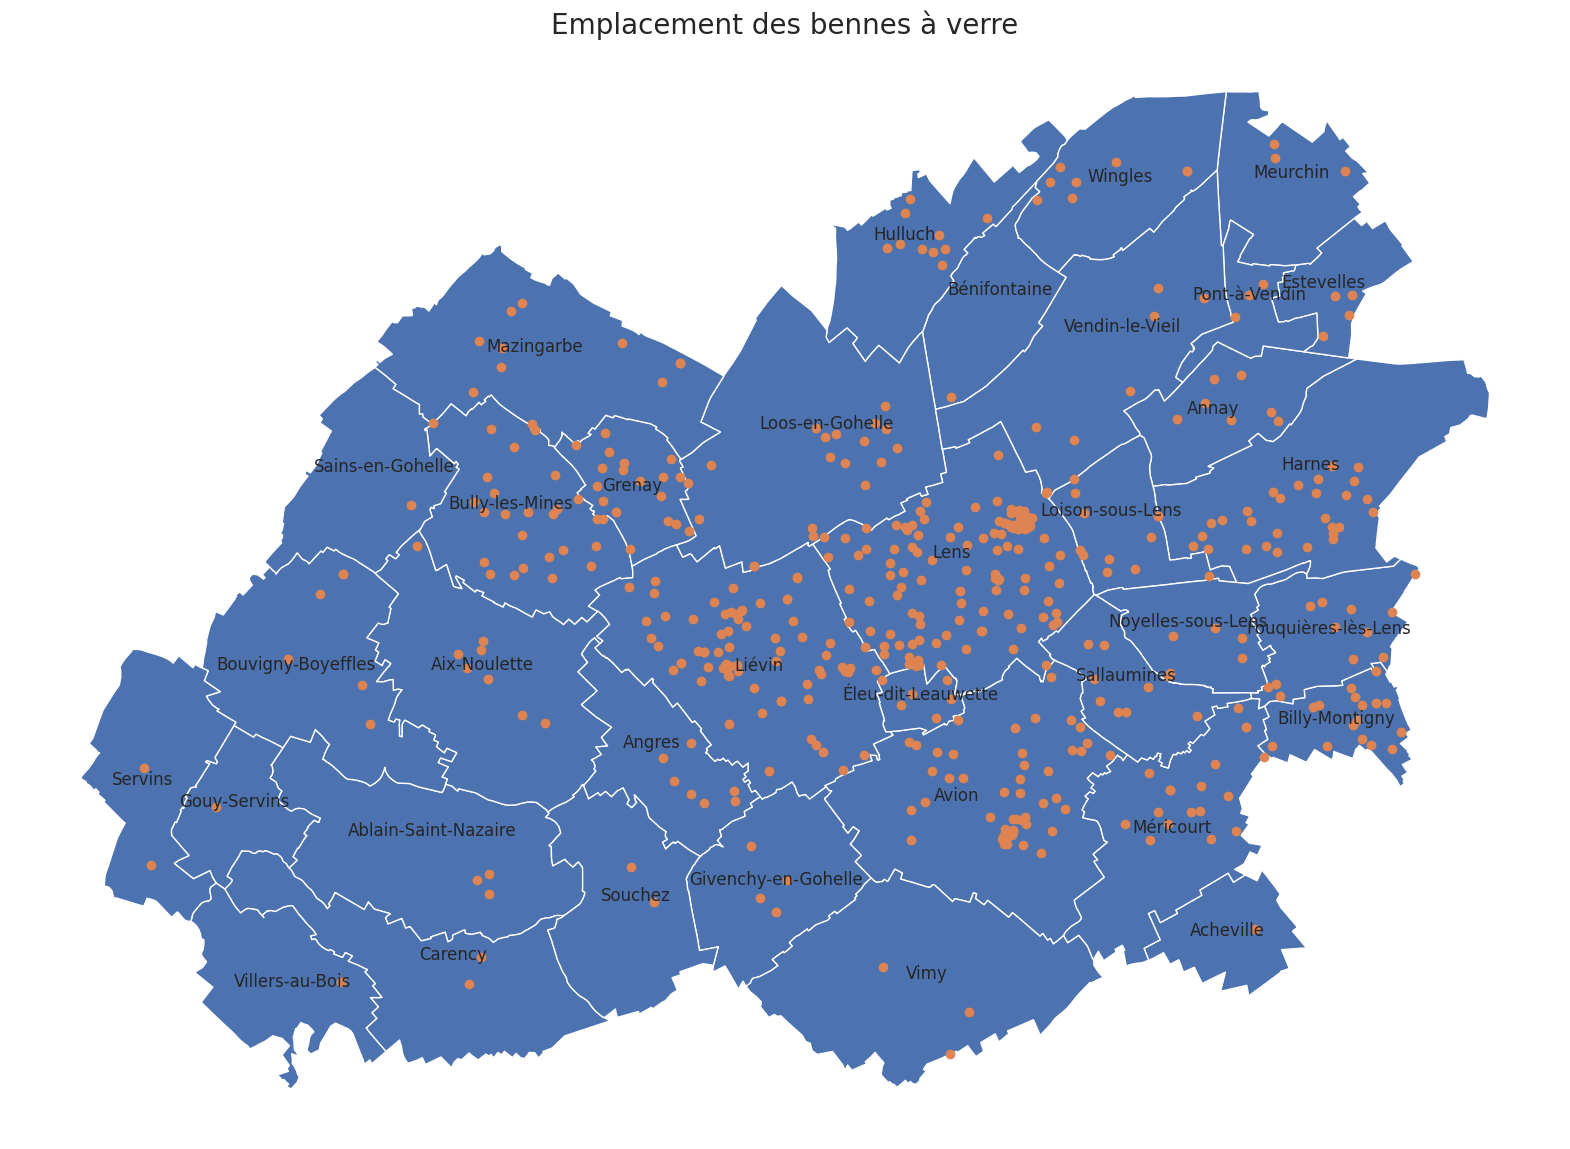

In [6]:
#carte

#creation de la figure matplotlib
fig,ax = plt.subplots(figsize=(20,20))
#affichage font de carte
font_carte.plot(ax=ax)

#annoté la carte
font_carte['coords'] = font_carte['geometry'].apply(lambda x: x.representative_point().coords[:])
font_carte['coords'] = [coords[0] for coords in font_carte['coords']]

for idx, row in font_carte.iterrows():
    plt.annotate(text=row['Libelle'], xy=row['coords'], horizontalalignment='center')
    
#creation des points oú sont les bennes
carte_benne.plot(ax=ax,color=palette[1])
ax.set_title('Emplacement des bennes à verre',fontsize=20)
ax.axis('off')
plt.show()


Sans grande surprise, les bennes se situent au niveau des grandes villes. 

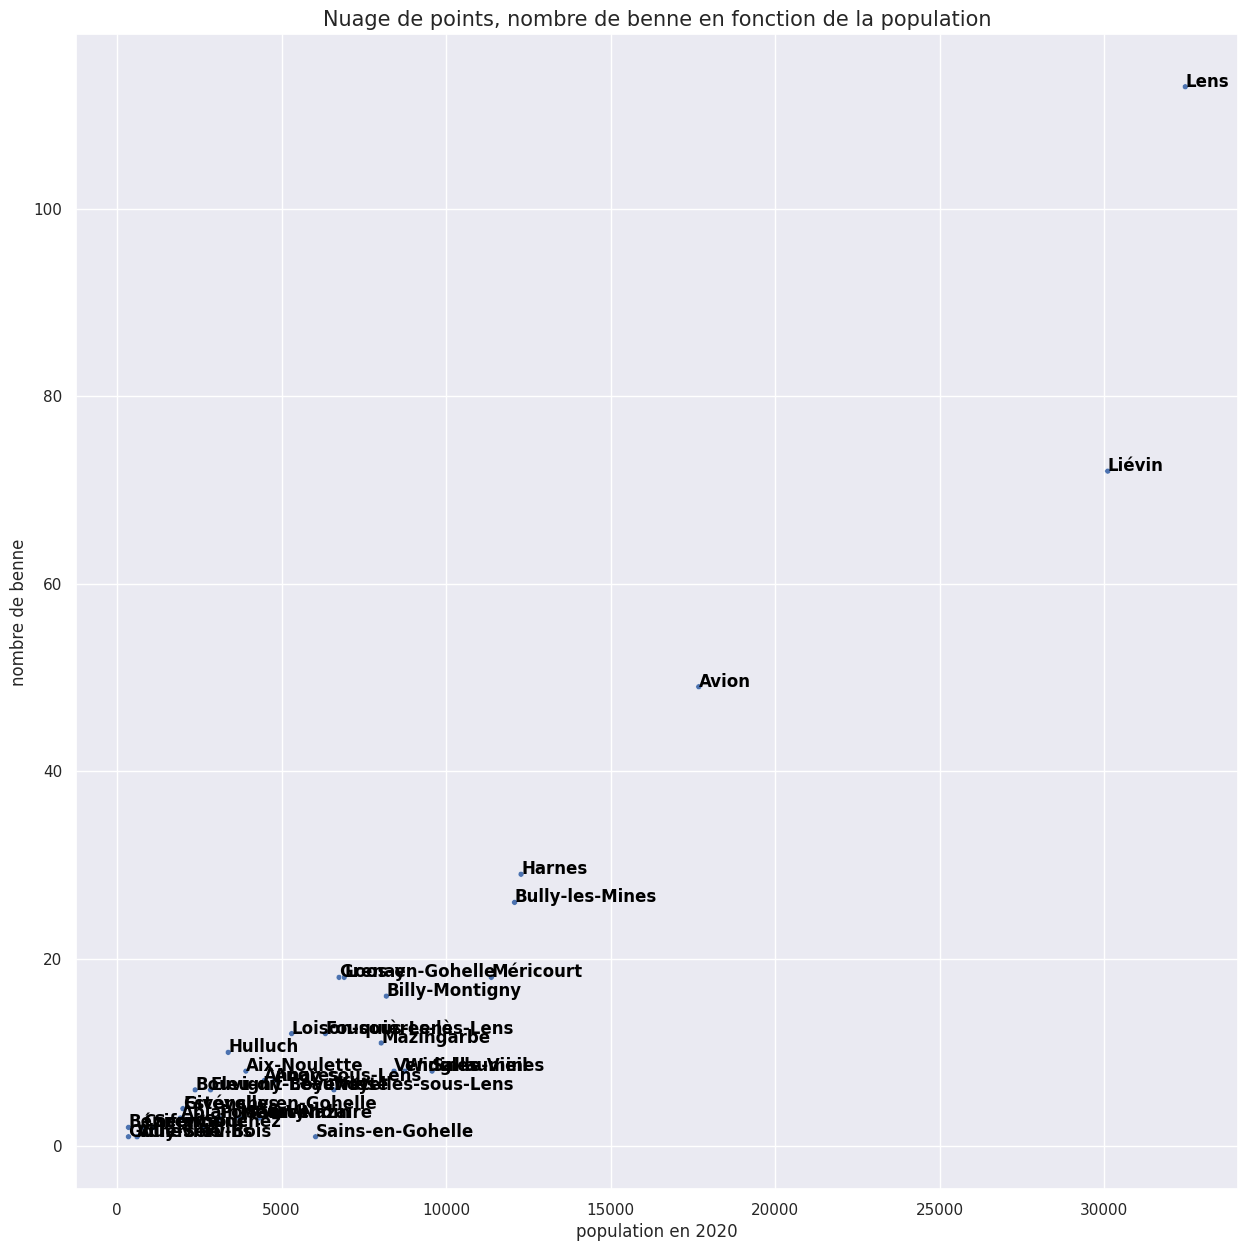

In [7]:
#affichage graphe
sns.set_theme(style='darkgrid')
#nuage de point population/nbbenne
fig, ax = plt.subplots(figsize=(15,15))
scatter_text(ax=ax,data = benne_verre , x='Population_municipale_2020',y='nb_benne',text_column='commune')

ax.set_title('Nuage de points, nombre de benne en fonction de la population',fontsize=15)
ax.set_xlabel('population en 2020')
ax.set_ylabel('nombre de benne')
plt.show()


Au plus la ville est peuplée, au plus il y a de benne.<br>
Par contre Sains-en-gohelle devrait avoir logiquement avoir plus de benne à verre.<br>

In [8]:
display(benne_verre[['nb_benne','Population_municipale_2020','volume_borne__m3_']].corr(numeric_only=True))

,nb_benne,Population_municipale_2020,volume_borne__m3_
nb_benne,1.000000,0.945659,0.979385
Population_municipale_2020,0.945659,1.000000,0.936038
volume_borne__m3_,0.979385,0.936038,1.000000


Les données sont fortement corrélées.

intercept (const dans statmodels) -6.6817118452719075
Coefficients: 
 [0.00317483]
Erreur des moindres carrés train : 50.07
Coefficient de determination train : 0.90
erreur max train:  16.633202404364113
score train : 0.895257042660921
score test : 0.8534184482492035


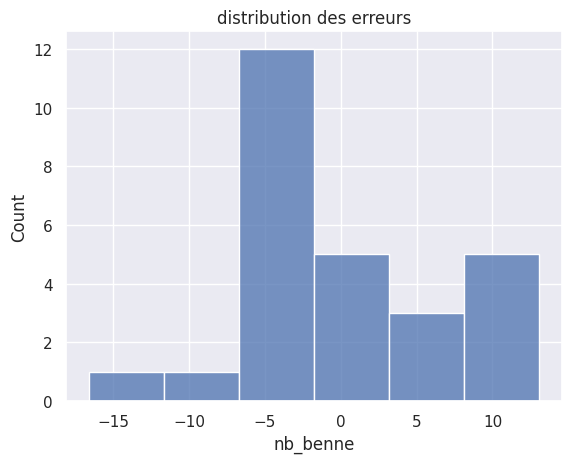


 test de Normalité des erreurs


Interprétation du test:
H0 : La série suit une loi Normale
H1 : La série ne suit pas une loi Normale
Étant donné que la p-values est supérieure au niveau de signification alpha = 0.05 ,
on ne peut pas rejeter l'hypothèse nulle H0.
Le risque de rejeter l'hypothèse nulle H0 alors qu'elle est vraie est inferieur à  5.0 %


                            OLS Regression Results                            
Dep. Variable:               nb_benne   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     213.7
Date:                Tue, 21 Mar 2023   Prob (F-statistic):           9.38e-14
Time:                        13:08:51   Log-Likelihood:                -91.142
No. Observations:                  27   AIC:                             186.3
Df Residuals:                      25   BIC:                             188.9
Df Model:   

In [9]:
Model_reg_lin = perso_reg_lin.auto_regression_lineaire(data=benne_verre[['nb_benne','Population_municipale_2020']],colonne_cible='nb_benne')

Le R² est très bon 90%. Les erreurs sont réparties selon une loi normale. On peut donc utiliser cette régression pour prédire le nombre de bennes dans une ville de la CALL est possible.

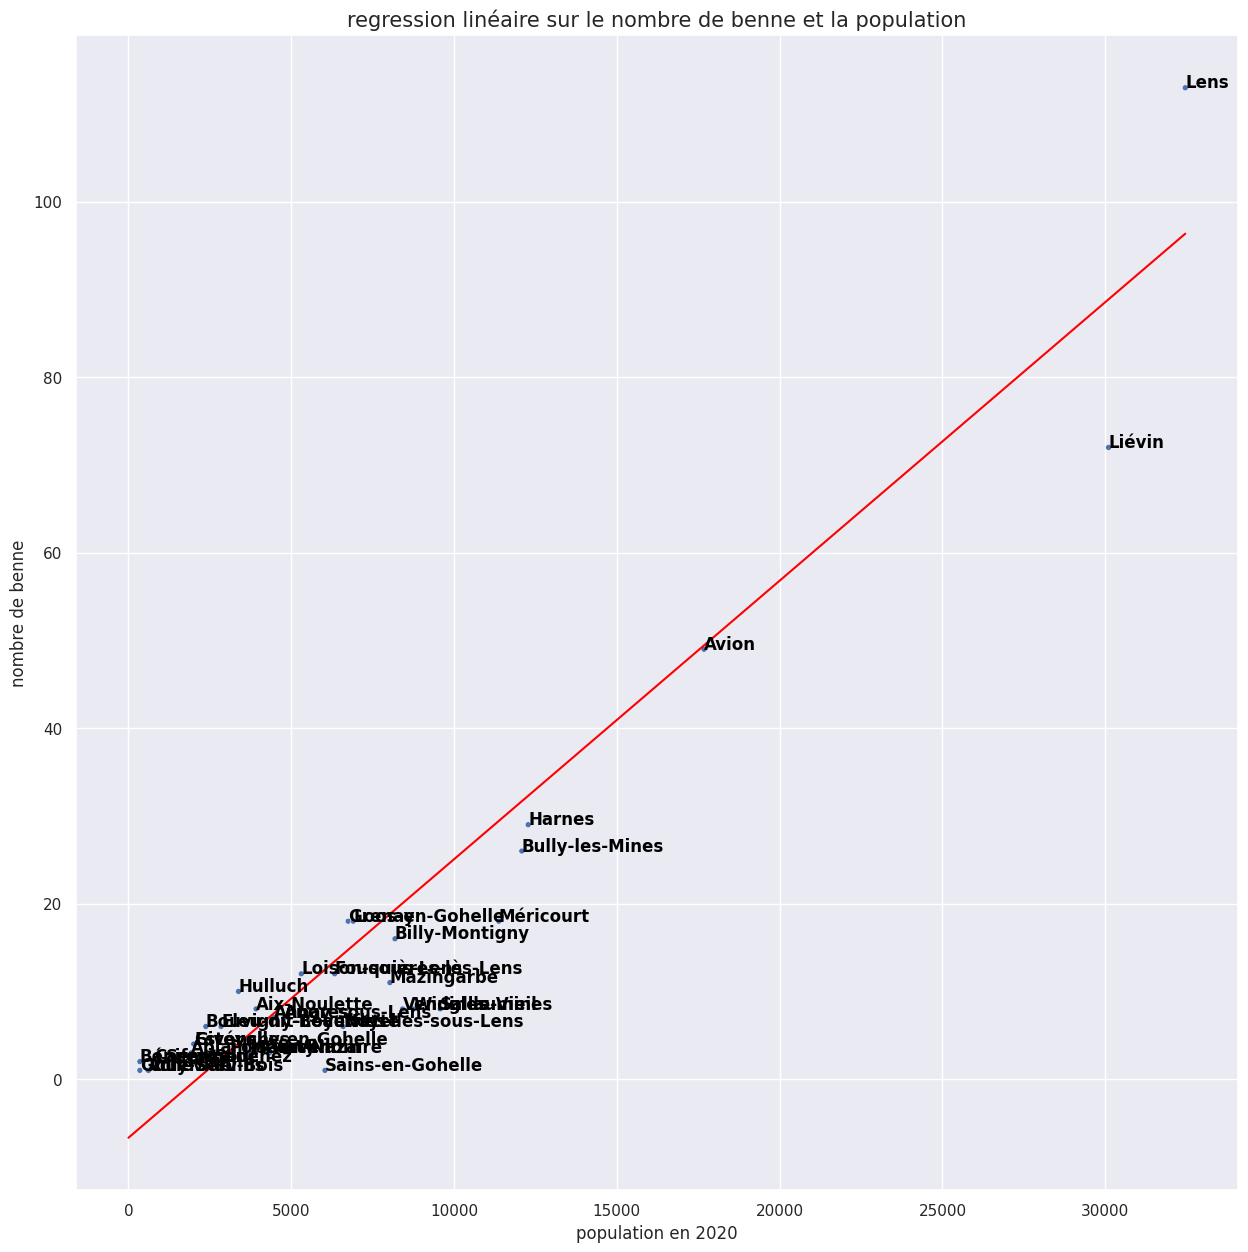

In [10]:
#affichage graphe
sns.set_theme(style='darkgrid')

#calcul pour afficher le graphe
a = Model_reg_lin.coef_
b = Model_reg_lin.intercept_
pop_max = benne_verre["Population_municipale_2020"].max()
ordonne = np.linspace(0,pop_max,1000)

#nuage de point population/nbbenne
fig, ax = plt.subplots(figsize=(15,15))
scatter_text(ax=ax,data = benne_verre , x='Population_municipale_2020',y='nb_benne',text_column='commune')

#sns.regplot(x = 'Population_municipale_2020', y = 'nb_benne', data = benne_verre,ax=ax,ci=None)
ax.plot(ordonne,a*ordonne+b,color='red')

ax.set_title('regression linéaire sur le nombre de benne et la population',fontsize=15)
ax.set_xlabel('population en 2020')
ax.set_ylabel('nombre de benne')
plt.show()


On affiche simplement la régression linéaire en rouge.

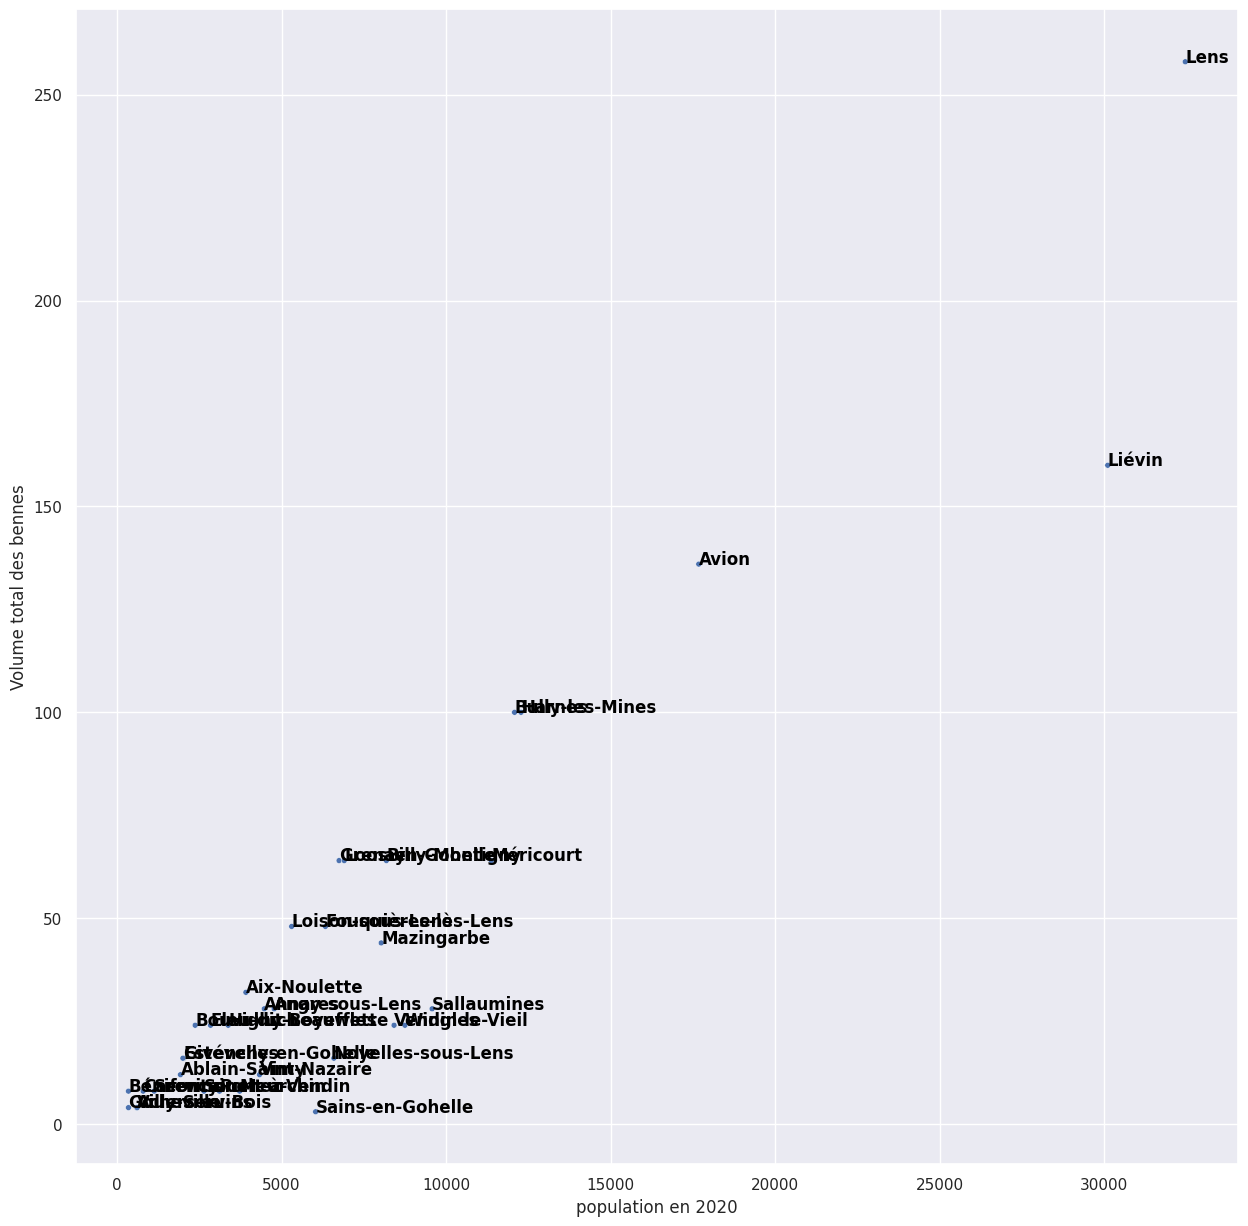

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_text(ax=ax,data = benne_verre , x='Population_municipale_2020',y='volume_borne__m3_',text_column='commune')
    
ax.set_xlabel('population en 2020')
ax.set_ylabel('Volume total des bennes')
plt.show()


Si on regarde le volume des bennes, il y a peu de changement. Le cas de sains-en-gohelle est toujours étrange

In [12]:
benne_verre["moyenne d'habitant par benne"] = benne_verre['Population_municipale_2020']/benne_verre['nb_benne']

## Cas de Bouvigny-Boyeffles

In [13]:
display(benne_verre[benne_verre['commune'] == 'Bouvigny-Boyeffles'])


,commune,volume_borne__m3_,trappe_gros_producteurs,cliiink,consignes_de_tri_à_jour,nb_benne,Population_municipale_2020,moyenne d'habitant par benne
7,Bouvigny-Boyeffles,24.0,0,2,0,6,2376,396.0


Avec une moyenne de 396 habitants par benne, Bouvigny-Boyeffles possède un nombre correct de benne à verre.

## Cas de Sains-en-Gohelle

In [14]:
display(benne_verre[benne_verre['commune'] == 'Sains-en-Gohelle'])

,commune,volume_borne__m3_,trappe_gros_producteurs,cliiink,consignes_de_tri_à_jour,nb_benne,Population_municipale_2020,moyenne d'habitant par benne
28,Sains-en-Gohelle,3.0,1,0,1,1,6035,6035.0


Avec une seule benne pour toute sa population (6035 âmes), le cas de Sains-en-Gohelle est étrange.<br>
Connaissant là un peu la ville, j'ai remarqué plusieurs containeurs.

In [15]:
data_Sains = benne_verre[benne_verre['commune'] == 'Sains-en-Gohelle']
nb_sains = int(Model_reg_lin.predict(data_Sains[['Population_municipale_2020']]))
print("Le nombre de containeurs de Sains-en-Gohelle devrait être de :",nb_sains)

Le nombre de containeurs de Sains-en-Gohelle devrait être de : 12
